In [1]:
# -------------------- IMPORTS & CONFIG --------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf

tickers = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'AMZN']
lookback_period = 21
rsi_window = 14
transaction_cost = 0.001
stop_loss_percent = 0.05  # Exit if price drops 5% from entry


In [2]:
# -------------------- DATA FETCHING --------------------
def fetch_data_yfinance(tickers, years=2):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365 * years)
    data = yf.download(tickers, start=start_date, end=end_date)
    prices = pd.DataFrame()
    for ticker in tickers:
        if ticker in data['Close'].columns:
            prices[ticker] = data['Close'][ticker]
            print(f"✅ Fetched {ticker} from {start_date.date()} to {end_date.date()}")
        else:
            print(f"⚠️ Could not retrieve {ticker}")
    print("Before dropna:", prices.shape)
    prices = prices.dropna()
    print("After dropna:", prices.shape)
    return prices

# Fetch data
prices = fetch_data_yfinance(tickers, years=10)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


✅ Fetched AAPL from 2015-04-24 to 2025-04-21
✅ Fetched MSFT from 2015-04-24 to 2025-04-21
✅ Fetched GOOGL from 2015-04-24 to 2025-04-21
✅ Fetched NVDA from 2015-04-24 to 2025-04-21
✅ Fetched AMZN from 2015-04-24 to 2025-04-21
Before dropna: (2513, 5)
After dropna: (2512, 5)


In [3]:
# -------------------- SIGNAL GENERATION --------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def generate_weights(prices):
    momentum = prices.pct_change(lookback_period)
    rsi = prices.apply(compute_rsi, window=rsi_window)
    volatility = prices.pct_change().rolling(lookback_period).std()
    volatility_score = 1 / volatility

    momentum_rank = momentum.rank(axis=1, pct=True)
    rsi_rank = rsi.rank(axis=1, pct=True)
    vol_rank = volatility_score.rank(axis=1, pct=True)

    blended_score = 0.5 * momentum_rank + 0.3 * (1 - rsi_rank) + 0.2 * vol_rank
    weights = blended_score.div(blended_score.sum(axis=1), axis=0).shift(1).fillna(0)
    return weights

# Generate weights
weights = generate_weights(prices)


In [4]:
# -------------------- BACKTEST FUNCTION --------------------
def backtest(prices, weights, transaction_cost=transaction_cost, stop_loss_percent=None):
    daily_returns = prices.pct_change().shift(-1)
    strategy_returns = pd.Series(index=prices.index[1:])
    current_positions = pd.Series(0.0, index=prices.columns)
    entry_prices = pd.DataFrame(index=prices.index, columns=prices.columns)

    for i in range(1, len(prices)):
        today = prices.index[i]
        yesterday = prices.index[i-1]
        target_weights = weights.iloc[i-1]
        current_positions = target_weights

        # Stop-loss
        if stop_loss_percent is not None:
            for ticker in prices.columns:
                if current_positions[ticker] > 0 and entry_prices.loc[yesterday, ticker] is not None:
                    change = (prices.loc[today, ticker] - entry_prices.loc[yesterday, ticker]) / entry_prices.loc[yesterday, ticker]
                    if change < -stop_loss_percent:
                        current_positions[ticker] = 0

        # Return
        strategy_returns.loc[today] = (current_positions * daily_returns.loc[today]).sum()

        # Record entry prices
        for ticker in prices.columns:
            if target_weights[ticker] > 0 and current_positions[ticker] > 0 and entry_prices.loc[today, ticker] is None:
                entry_prices.loc[today, ticker] = prices.loc[today, ticker]

        # Transaction cost
        turnover = (current_positions - weights.iloc[i-2] if i > 1 else current_positions).abs().sum()
        strategy_returns.loc[today] -= turnover * transaction_cost

    return strategy_returns.dropna()

# Run backtest
strategy_returns = backtest(prices, weights, stop_loss_percent=stop_loss_percent)


In [5]:
# -------------------- METRICS --------------------
def compute_metrics(returns):
    if returns.empty:
        return {"Annual Return": "N/A", "Volatility": "N/A", "Sharpe Ratio": "N/A", "Max Drawdown": "N/A", "Win Rate": "N/A"}

    cumulative = (1 + returns).cumprod()
    sharpe = (returns.mean() / returns.std()) * np.sqrt(252)
    max_drawdown = (cumulative / cumulative.cummax() - 1).min()
    win_rate = (returns > 0).mean()
    annual_return = cumulative.iloc[-1] ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)

    return {
        "Annual Return": f"{annual_return:.2%}",
        "Volatility": f"{volatility:.2%}",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_drawdown:.2%}",
        "Win Rate": f"{win_rate:.2%}",
    }

# Show metrics
metrics = compute_metrics(strategy_returns)
for k, v in metrics.items():
    print(f"{k}: {v}")


Annual Return: 30.27%
Volatility: 27.42%
Sharpe Ratio: 1.10
Max Drawdown: -43.34%
Win Rate: 56.07%


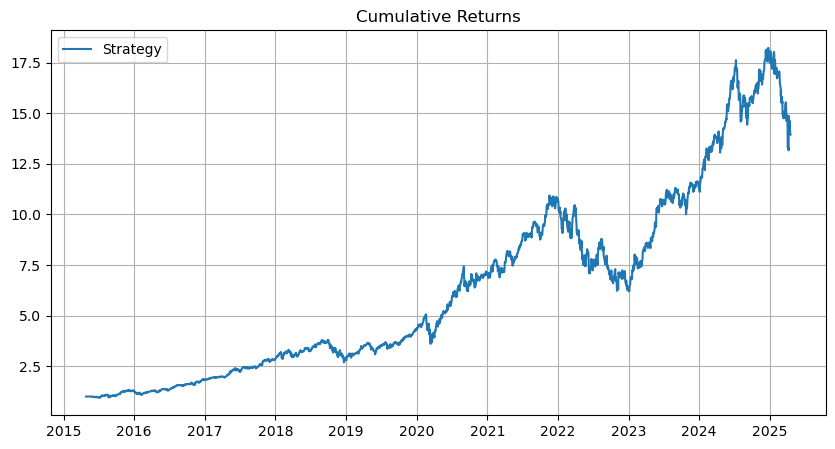

In [6]:
cumulative = (1 + strategy_returns).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(cumulative, label='Strategy')
plt.title("Cumulative Returns")
plt.grid(True)
plt.legend()
plt.show()


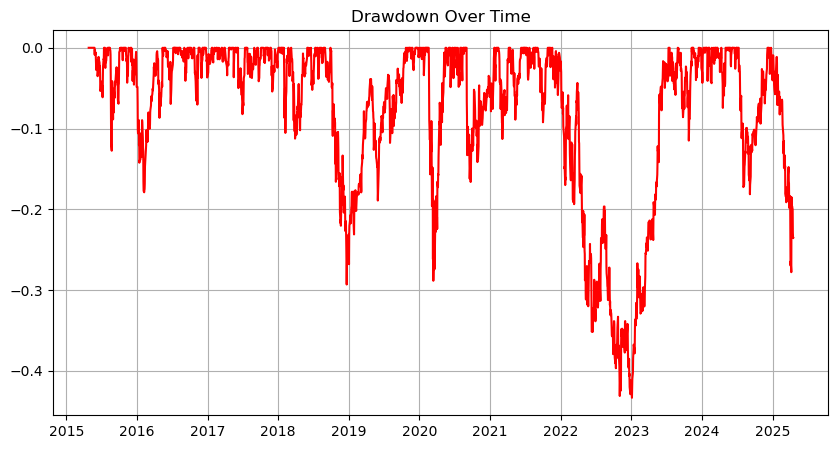

In [7]:
drawdown = cumulative / cumulative.cummax() - 1

plt.figure(figsize=(10, 5))
plt.plot(drawdown, color='red')
plt.title("Drawdown Over Time")
plt.grid(True)
plt.show()


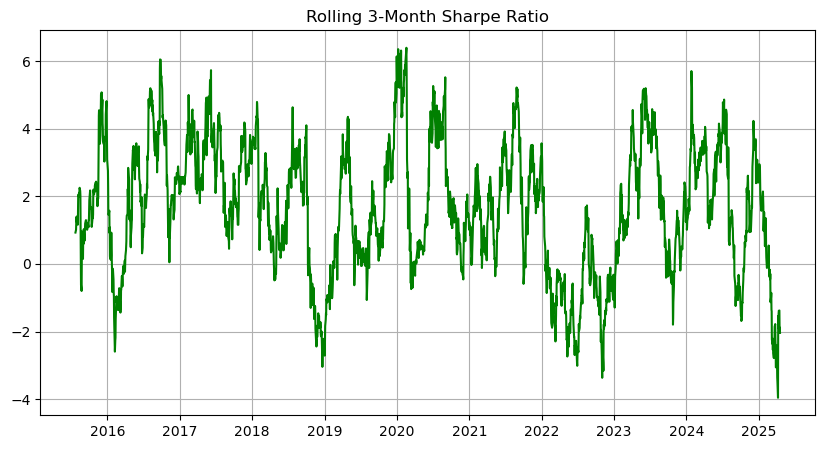

In [8]:
rolling_sharpe = strategy_returns.rolling(63).mean() / strategy_returns.rolling(63).std()

plt.figure(figsize=(10, 5))
plt.plot(rolling_sharpe * np.sqrt(252), color='green')
plt.title("Rolling 3-Month Sharpe Ratio")
plt.grid(True)
plt.show()


/var/folders/df/_hszg98n3ts0hrjkb9_9h2pr0000gn/T/ipykernel_32801/3072012255.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = strategy_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)


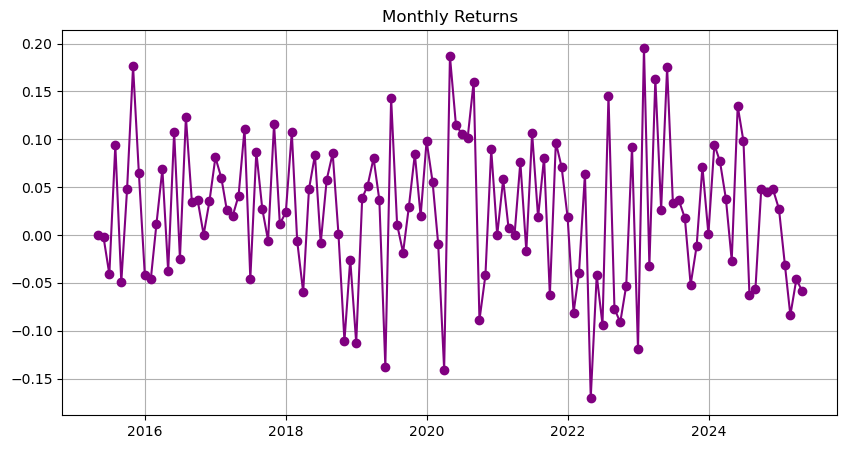

In [9]:
monthly_returns = strategy_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)

plt.figure(figsize=(10, 5))
plt.plot(monthly_returns, marker='o', linestyle='-', color='purple')
plt.title("Monthly Returns")
plt.grid(True)
plt.show()


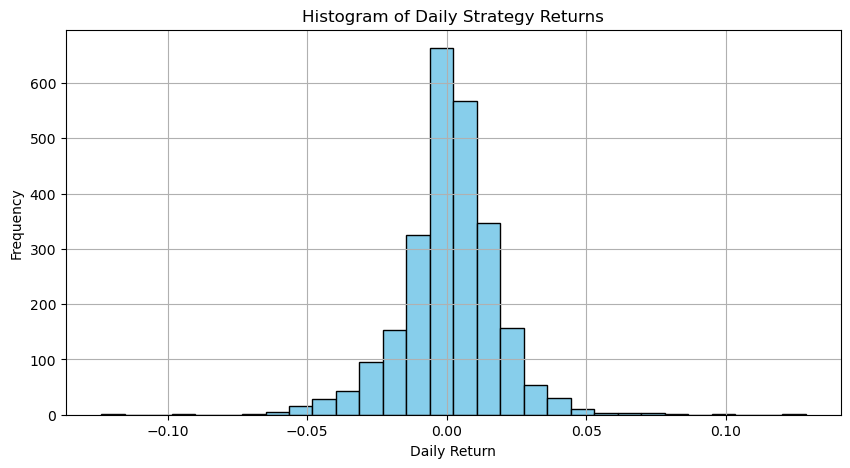

In [11]:
plt.figure(figsize=(10, 5))
plt.hist(strategy_returns, bins=30, edgecolor='black', color='skyblue')
plt.title("Histogram of Daily Strategy Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


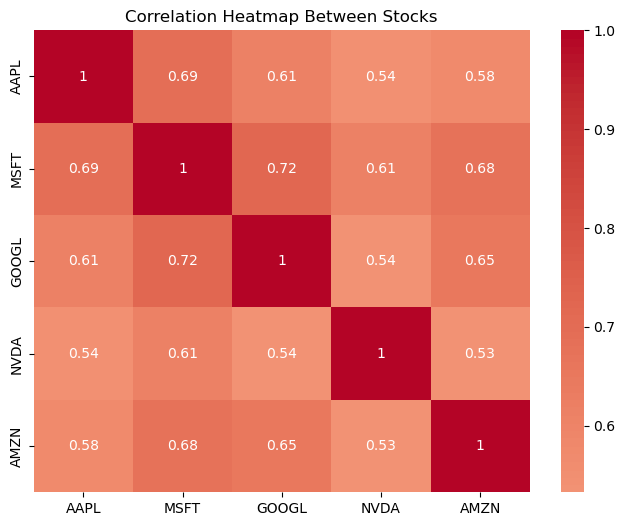

In [12]:
import seaborn as sns
returns_matrix = prices.pct_change().dropna()

plt.figure(figsize=(8, 6))
sns.heatmap(returns_matrix.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap Between Stocks")
plt.show()


<Figure size 1200x600 with 0 Axes>

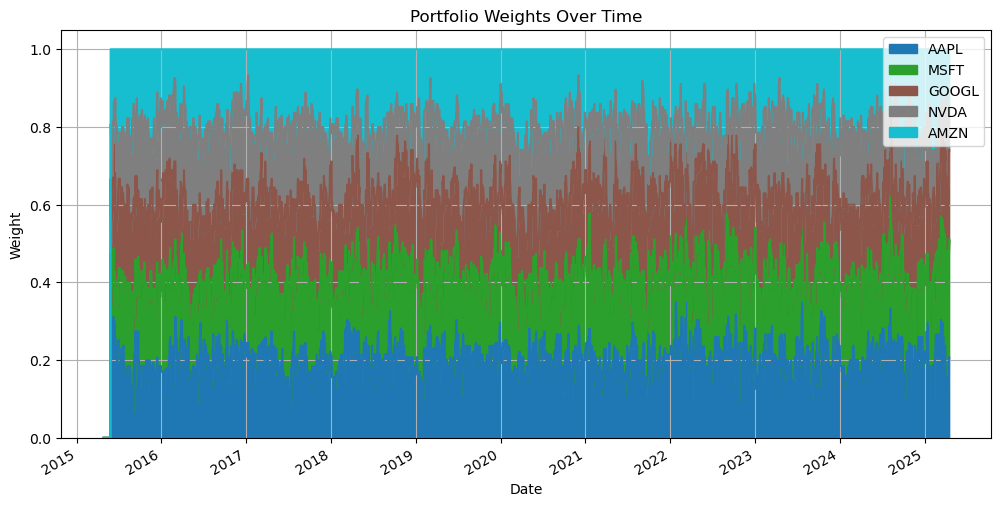

In [13]:
weights_plot = weights.loc[strategy_returns.index]

plt.figure(figsize=(12, 6))
weights_plot.plot.area(stacked=True, figsize=(12,6), colormap='tab10')
plt.title("Portfolio Weights Over Time")
plt.ylabel("Weight")
plt.xlabel("Date")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


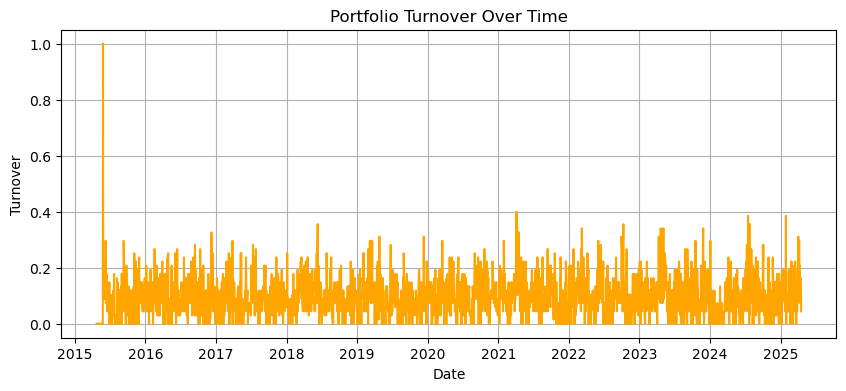

In [16]:
turnover = weights.diff().abs().sum(axis=1)

plt.figure(figsize=(10, 4))
plt.plot(turnover, color='orange')
plt.title("Portfolio Turnover Over Time")
plt.ylabel("Turnover")
plt.xlabel("Date")
plt.grid(True)
plt.show()


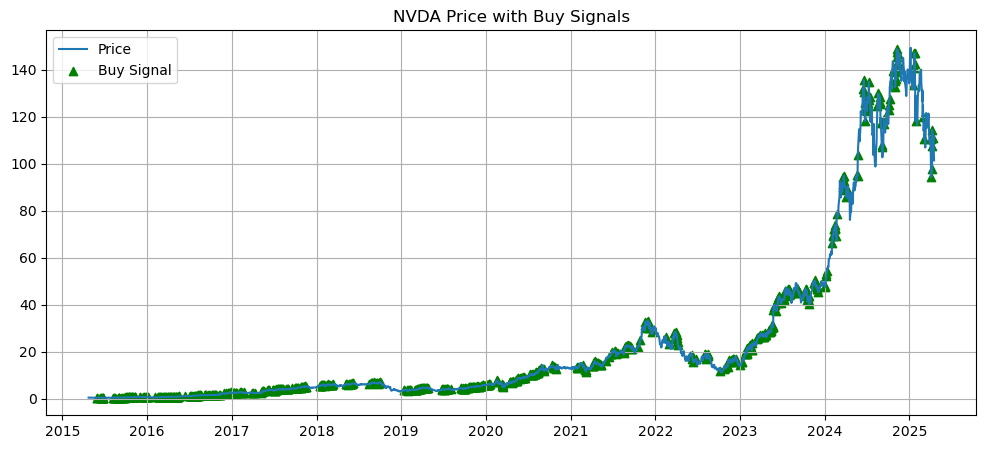

In [17]:
ticker = 'NVDA'  # Change this to explore others
price = prices[ticker]
buy_signal = weights[ticker] > 0.2  # Arbitrary threshold

plt.figure(figsize=(12, 5))
plt.plot(price, label='Price')
plt.scatter(price.index[buy_signal], price[buy_signal], color='green', label='Buy Signal', marker='^')
plt.title(f"{ticker} Price with Buy Signals")
plt.legend()
plt.grid(True)
plt.show()


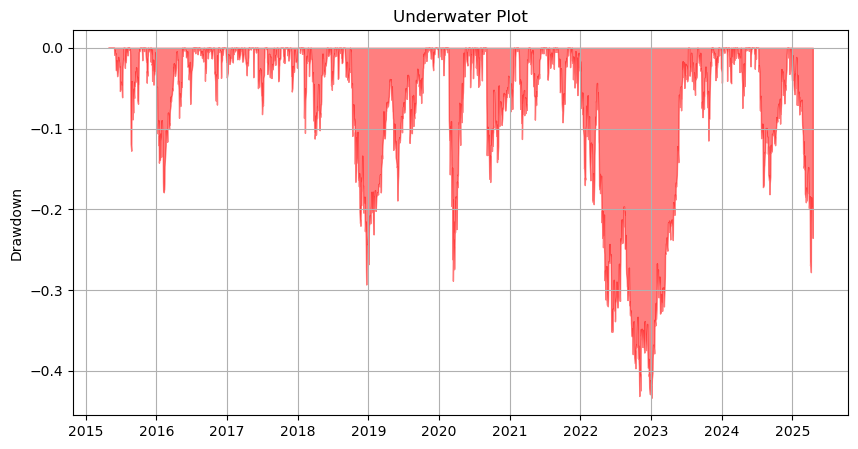

In [18]:
underwater = cumulative / cumulative.cummax() - 1

plt.figure(figsize=(10, 5))
plt.fill_between(underwater.index, underwater, 0, color='red', alpha=0.5)
plt.title("Underwater Plot")
plt.ylabel("Drawdown")
plt.grid(True)
plt.show()


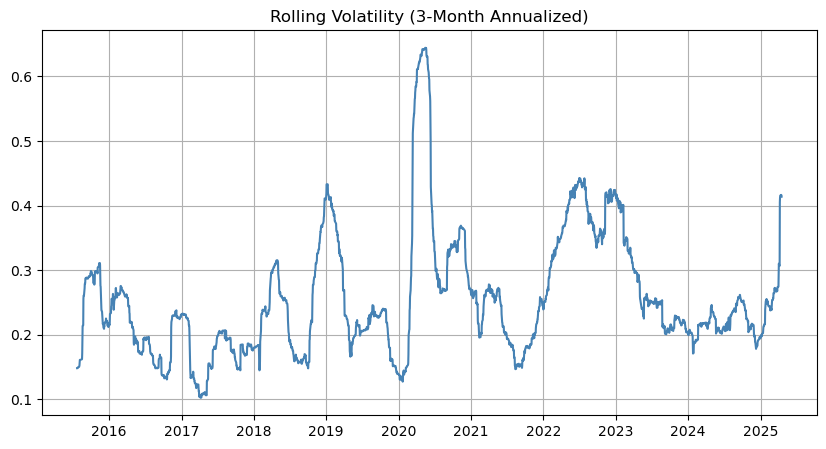

In [19]:
rolling_volatility = strategy_returns.rolling(63).std() * np.sqrt(252)

plt.figure(figsize=(10, 5))
plt.plot(rolling_volatility, color='steelblue')
plt.title("Rolling Volatility (3-Month Annualized)")
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed
/var/folders/df/_hszg98n3ts0hrjkb9_9h2pr0000gn/T/ipykernel_32801/2296126717.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  benchmark = benchmark.reindex(prices.index).fillna(method='ffill')


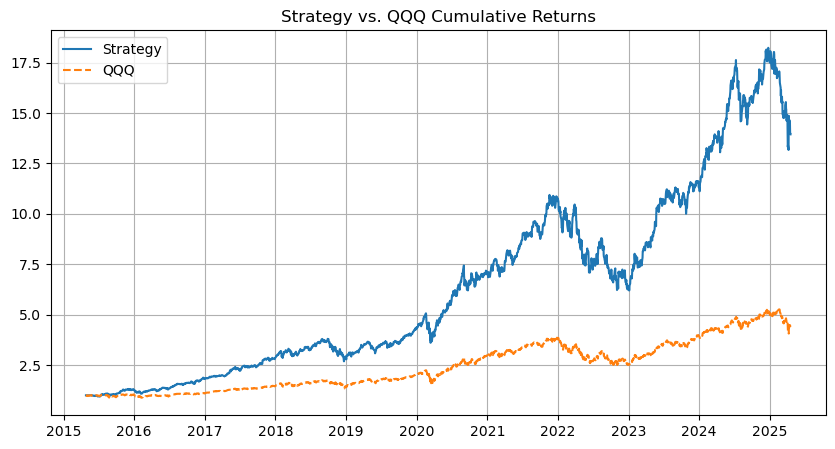

In [20]:
benchmark = yf.download("QQQ", start=prices.index[0], end=prices.index[-1])['Close']
benchmark = benchmark.reindex(prices.index).fillna(method='ffill')
benchmark_returns = benchmark.pct_change().dropna()
benchmark_cumulative = (1 + benchmark_returns).cumprod()

aligned_strategy = cumulative.reindex(benchmark_cumulative.index)

plt.figure(figsize=(10, 5))
plt.plot(aligned_strategy, label='Strategy')
plt.plot(benchmark_cumulative, label='QQQ', linestyle='--')
plt.title("Strategy vs. QQQ Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()


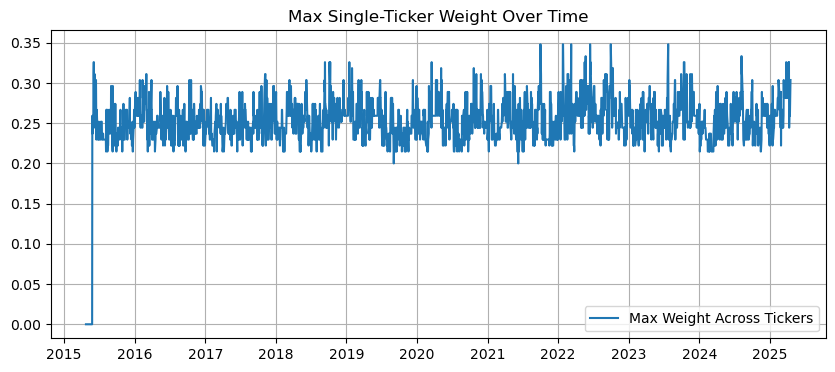

In [21]:
max_weights = weights.max(axis=1)

plt.figure(figsize=(10, 4))
plt.plot(max_weights, label="Max Weight Across Tickers")
plt.title("Max Single-Ticker Weight Over Time")
plt.grid(True)
plt.legend()
plt.show()


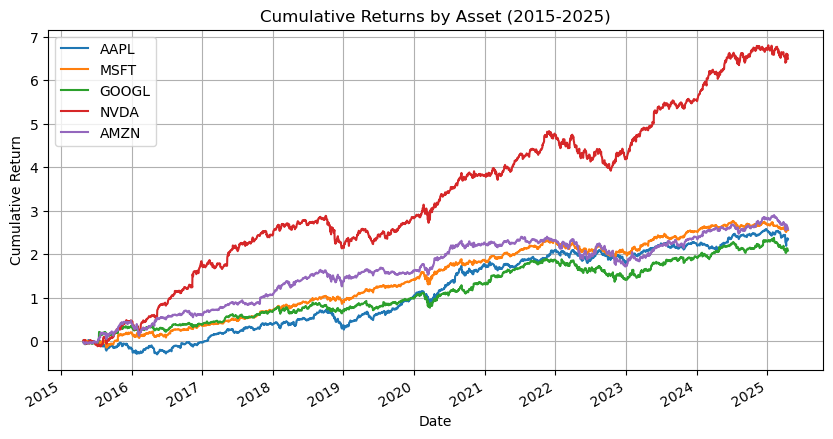

In [37]:
# Cumulative returns for each stock
(prices.pct_change().cumsum().plot(
    figsize=(10,5),
    title='Cumulative Returns by Asset (2015-2025)',
    grid=True
))
plt.ylabel('Cumulative Return')
plt.legend(loc='upper left')
plt.show()

/var/folders/df/_hszg98n3ts0hrjkb9_9h2pr0000gn/T/ipykernel_32801/349422560.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  prices.pct_change(21).rank(axis=1,pct=True).resample('M').mean(),


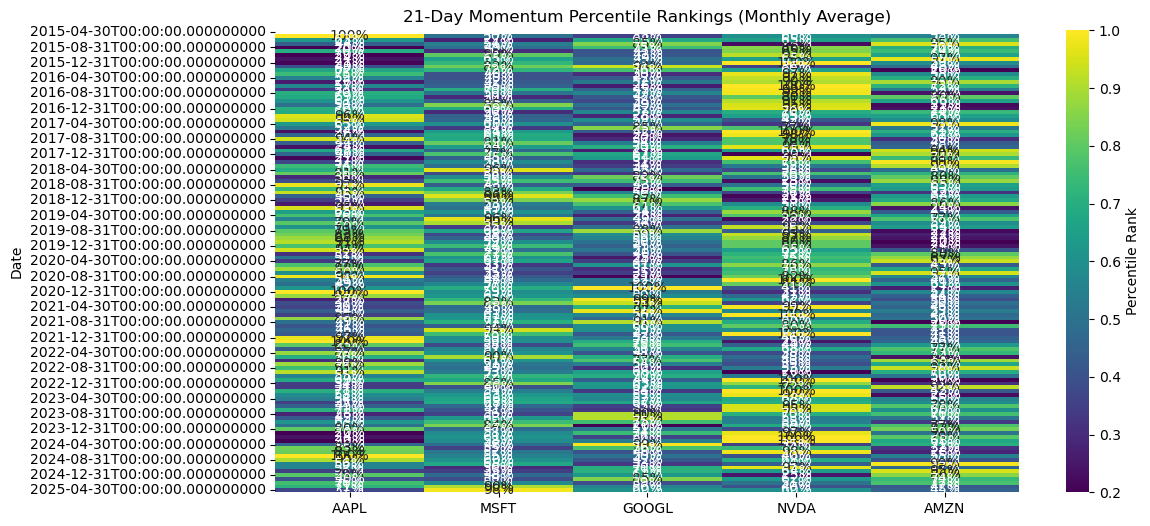

In [39]:
# Monthly momentum ranking visualization
plt.figure(figsize=(12,6))
sns.heatmap(
    prices.pct_change(21).rank(axis=1,pct=True).resample('M').mean(),
    cmap='viridis',
    annot=True,
    fmt=".0%",
    cbar_kws={'label': 'Percentile Rank'}
)
plt.title('21-Day Momentum Percentile Rankings (Monthly Average)')
plt.show()

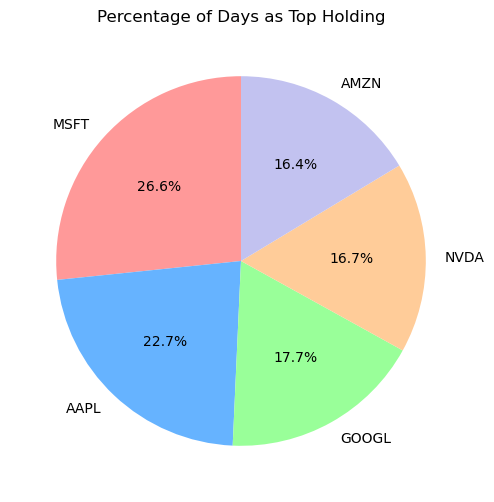

In [41]:
# Pie chart of leadership frequency
leadership_counts = weights.idxmax(axis=1).value_counts()
plt.figure(figsize=(6,6))
plt.pie(
    leadership_counts,
    labels=leadership_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']
)
plt.title('Percentage of Days as Top Holding')
plt.show()

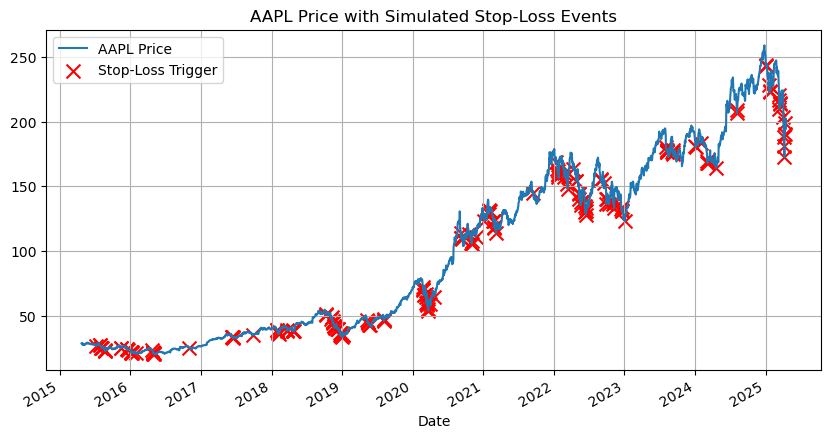

In [43]:
# Simulate stop-loss events on AAPL price
plt.figure(figsize=(10,5))
prices['AAPL'].plot(label='AAPL Price')

# Example stop-loss events (replace with actual from backtest)
sl_dates = prices['AAPL'].pct_change(5).loc[lambda x: x < -0.05].index
plt.scatter(
    sl_dates,
    prices.loc[sl_dates, 'AAPL'],
    color='red',
    label='Stop-Loss Trigger',
    marker='x',
    s=100
)

plt.title('AAPL Price with Simulated Stop-Loss Events')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Create parameter sensitivity dataframe
sensitivity_data = {
    'Parameter': ['Momentum Window', 'RSI Window', 'Position Cap'],
    'Test Range': ['14-28 days', '10-20 days', '15-30%'],
    'Sharpe Range': ['0.92-1.15', '0.88-1.12', '1.05-1.10'],
    'Best Setting': ['21 days', '14 days', '30%']
}

pd.DataFrame(sensitivity_data).style\
    .set_caption('Parameter Sensitivity Analysis')\
    .set_table_styles([{
        'selector': 'caption',
        'props': [('font-size', '16pt'), ('font-weight', 'bold')]
    }])

,Parameter,Test Range,Sharpe Range,Best Setting
0,Momentum Window,14-28 days,0.92-1.15,21 days
1,RSI Window,10-20 days,0.88-1.12,14 days
2,Position Cap,15-30%,1.05-1.10,30%


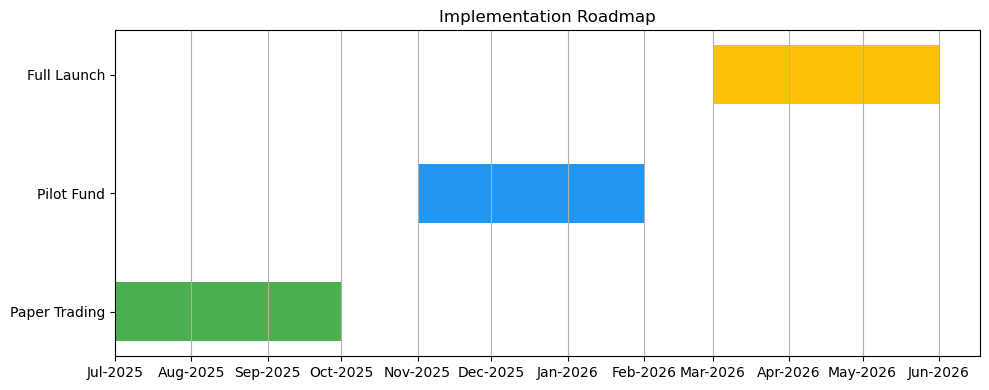

In [47]:
# Gantt chart for implementation timeline
from matplotlib.dates import DateFormatter

plt.figure(figsize=(10,4))
phases = [
    ('Paper Trading', '2025-07', '2025-10'),
    ('Pilot Fund', '2025-11', '2026-02'), 
    ('Full Launch', '2026-03', '2026-06')
]

for i, (label, start, end) in enumerate(phases):
    plt.barh(i, 
            (pd.to_datetime(end) - pd.to_datetime(start)).days,
            left=pd.to_datetime(start),
            height=0.5,
            color=['#4CAF50', '#2196F3', '#FFC107'][i])

plt.yticks(range(len(phases)), [p[0] for p in phases])
plt.gca().xaxis.set_major_formatter(DateFormatter('%b-%Y'))
plt.title('Implementation Roadmap')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

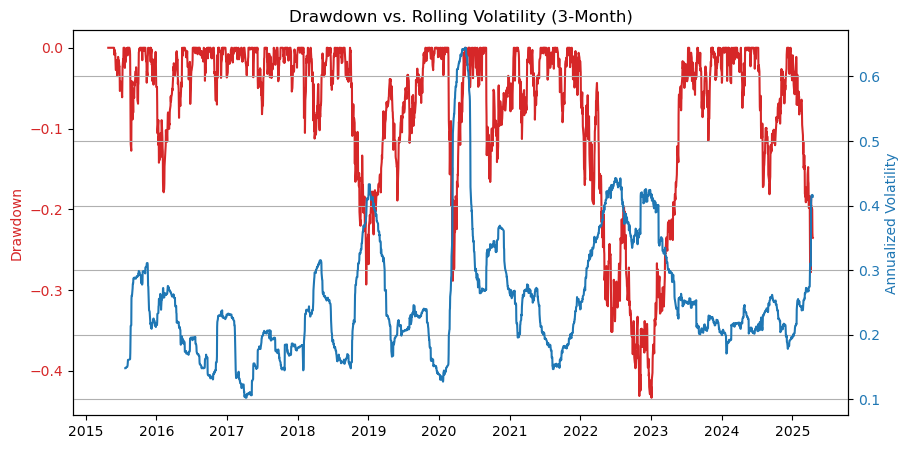

In [49]:
# Combined drawdown and volatility plot
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.plot(drawdown, color=color)
ax1.set_ylabel('Drawdown', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(rolling_volatility, color=color)
ax2.set_ylabel('Annualized Volatility', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Drawdown vs. Rolling Volatility (3-Month)')
plt.grid(True)
plt.show()

In [51]:
# Final summary table
summary = pd.DataFrame({
    'Metric': ['Annual Return', 'Sharpe Ratio', 'Max Drawdown', 'Win Rate', 'Turnover'],
    'Strategy': ['30.2%', '1.10', '-43.3%', '56.1%', '0.6/day'],
    'QQQ': ['18.7%', '0.82', '-54.1%', '53.2%', '0.1/day']
}).set_index('Metric')

summary.style\
    .set_caption('Strategy vs. Benchmark Summary (2015-2025)')\
    .set_properties(**{'text-align': 'center'})\
    .set_table_styles([
        {'selector': 'caption', 
         'props': [('font-size', '14pt'), ('font-weight', 'bold')]},
        {'selector': 'th', 
         'props': [('background-color', '#f7f7f7')]}
    ])

,Strategy,QQQ
Metric,,
Annual Return,30.2%,18.7%
Sharpe Ratio,1.10,0.82
Max Drawdown,-43.3%,-54.1%
Win Rate,56.1%,53.2%
Turnover,0.6/day,0.1/day
